<a href="https://www.kaggle.com/kevinkwan/the-formula-1-fantasy-dream-team?scriptVersionId=89610471" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Objective

As Formula 1 enthusiast, participating in a Formula 1 fantasy league is an entertaining way to keep up with the sport. This dataset is great to see if I will be able to optimize the driver and constructor selections for my Formula 1 fantasy team.

The Formula 1 fantasy league is based on a selecting a team of 5 drivers and 1 constructor week to week with a budget of $100MM dollars to acquire the various drivers.

As with any fantasy sport, we all want to have an edge over our competition and why not use data to our advantage.

What this notebook will aim to do:
* Explore the dataset and see if there are any correlations and trends regarding the available data
* Data cleaning and formatting in order to have the data useful for manipulation
* Visualize the trends for optimal fantasy points value
* Identify the optimal Formula 1 fantasy team week by week to maximize overall fantasy point performance over the course of the season (2021)

<hr>

# Background Information

The purpose of this notebook is use data and improve selection of a Formula 1 fantasy team. There are different approaches, but we'll aim to go with some low hanging fruit. First of all it is important to understand how the Formula 1 fantasy league functions.

**Formula 1 Fantasy Format**
* A fantasy team consists of 6 positions (5 drivers and 1 constructor).
* Budget of <span>$</span>100MM to purchase and fill all 6 positions
* The objective is to maximize fantasy points acquired
* Fantasy points are acquired based on the performance of your team on a race by race basis
* Fantast points are accumulated based on a scoring system (see below for more info)
* Your fantasy team may be changed between race to race to select optimal drivers/constructor
* There are additional scoring bonuses (i.e. Mega Driver, Turbo Driver) that we will not be considering in this notebook
* Find additional information in the following link: <a href='https://www.formula1.com/en/latest/article.f1-fantasy-how-to-play-the-essential-guide-to-get-you-started.5hI9i2D18x4RGhVecwrQjF.html'>F1 FANTASY: How to play – the essential guide to get you started</a>

**Fantasy Points Scoring System**
The scoring system falls under 3 main sections:
* Qualifying
    * Qualifying Position (1st = 10pts, 2nd = 9 pts, ... 10th = 1 pt, 11+ = 0 pts)
    * Participation in Qualifying Rounds (Q1 = 1 pt, Q2 = 2 pts, Q3 = 3 pts)
    * Outqualified teammate = 2 pts
* Race 
    * Finishing Position (1st = 25 pts, 2nd = 18 pts, ... 10th = 1 pt)
    * Finished the race = 1 pt
    * Per Position Gained = 2 pts (max 10 pts)
    * Per Position Lost = -2 pts (max -10 pts if started top 10)
    * Per Position Lost = -1 pts (max -5 pts if started bottom 10)
    * Finished ahead of teammate = 3 pts
    * Fastest lap = 1 pt
    * Not classified = -15 pts
    * Disqualification = -20 pts 
* Streak
    * Driver qualifies in top 10 for 5 races in a row = 5 pts
    * Driver finishes in top 10 for 5 races in a row = 5 pts
    * Constructor has both drivers qualify in top 10 for 3 races in a row = 5 pts
    * Constructor has both drivers finish race in top 10 for 3 races in a row = 10 pts
* More on the <a href='https://inews.co.uk/sport/formula-one/f1-fantasy-2021-tips-scoring-system-rules-how-pick-drivers-team-formula-one-game-915668'>F1 Fantasy Scoring</a>

<hr>

# Methodology

We'll start off exploring the data to find out the various information available and come up with parameters that we can use to optimize fantasy points to the amount of money to spend on the team.

From here, we'll start drawing some insights from the various visualizations and data manipulations. It will be here where we start to construct

As a final note of interest we'll take a peek to see what we needed to do to produce a theoretically optimal solution to maximize our fantasy team from week to week.

We'll finish off with some discussion and conclusions of the results.

Let's begin!

<hr>

# Setup and Data Retrieval

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
import re

pio.templates.default = 'seaborn'
sns.set_style('whitegrid')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
files = []
print('*'*100+'\n')
print('File Directories\n')
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        files.append(os.path.join(dirname,filename))
print('\n'+'*'*100+'\n')

# Organizing performance files into Constructors & Drivers
constructor_performance_files = [x for x in filenames if ('constructor' in x.split('_')) and ('value.csv' not in x.split('_'))]
print('Constructor Performance Files\n')
print(constructor_performance_files)

print('\n'+'*'*100+'\n')
driver_performance_files = [x for x in filenames if ('driver' in x.split('_')) and ('value.csv' not in x.split('_'))]
print('Driver Performance Files\n')
print(driver_performance_files)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

****************************************************************************************************

File Directories

/kaggle/input/formula-1-fantasy-2021/usa_constructor_performance.csv
/kaggle/input/formula-1-fantasy-2021/bahrain_constructor_performance.csv
/kaggle/input/formula-1-fantasy-2021/mexico_driver_performance.csv
/kaggle/input/formula-1-fantasy-2021/mexico_constructor_performance.csv
/kaggle/input/formula-1-fantasy-2021/netherlands_driver_performance.csv
/kaggle/input/formula-1-fantasy-2021/belgium_constructor_performance.csv
/kaggle/input/formula-1-fantasy-2021/italy_constructor_performance.csv
/kaggle/input/formula-1-fantasy-2021/abudhabi_constructor_performance.csv
/kaggle/input/formula-1-fantasy-2021/belgium_driver_performance.csv
/kaggle/input/formula-1-fantasy-2021/styria_constructor_performance.csv
/kaggle/input/formula-1-fantasy-2021/britain_constructor_performance.csv
/kaggle/input/formula-1-fantasy-2021/usa_driver_performance.csv
/kaggle/input/formula-1-fantasy-

## Data Preview
From the files included, it appears we have:
* Driver performance data (race specific)
* Constructor performance data (race specific)
* Driver value data (consolidated)
* Constructor value data (consolidated)

### Value Summary Data

In [2]:
# Sample driver performance csv
df_driver_value = pd.read_csv('/kaggle/input/formula-1-fantasy-2021/driver_value.csv')
df_constructor_value = pd.read_csv('/kaggle/input/formula-1-fantasy-2021/constructor_value.csv')
display(df_driver_value.head(5))
display(df_driver_value.info())
display(df_constructor_value.head(5))
display(df_constructor_value.info())

,Driver Name,Bahrain GP,Imola GP,Portugal GP,Spain GP,Monaco GP,Azerbaijan GP,French GP,Styrian GP,Austrian GP,...,Dutch GP,Italian GP,Russian GP,Turkish GP,USA GP,Mexican GP,Brazilian GP,Qatar GP,Saudi Arabian GP,Abu Dhabi GP
0,Lewis Hamilton,33.5,33.4,33.4,33.3,33.3,33.3,33.2,33.1,33.1,...,33.0,33.0,33.0,33.0,33.1,33.0,32.9,32.9,32.9,32.9
1,Max Verstappen,24.8,25.1,25.2,25.3,25.3,25.4,25.5,25.5,25.6,...,25.7,25.7,25.7,25.6,25.6,25.7,25.6,25.7,25.7,25.7
2,Valtteri Bottas,23.6,23.5,23.4,23.2,23.3,23.1,23.0,23.0,23.0,...,23.0,23.0,23.0,23.4,23.3,23.2,23.4,23.2,23.3,23.3
3,Sergio Perez,18.4,18.4,18.3,18.3,18.2,18.0,18.3,18.5,18.8,...,18.5,18.5,18.4,18.3,18.2,18.4,18.5,18.6,18.5,18.5
4,Daniel Ricciardo,17.3,16.7,16.6,16.4,16.2,16.2,16.0,15.9,15.9,...,15.7,15.7,15.7,15.8,15.8,15.8,15.8,15.8,15.7,15.7


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Driver Name       20 non-null     object 
 1   Bahrain GP        20 non-null     float64
 2   Imola GP          20 non-null     float64
 3   Portugal GP       20 non-null     float64
 4   Spain GP          20 non-null     float64
 5   Monaco GP         20 non-null     float64
 6   Azerbaijan GP     20 non-null     float64
 7   French GP         20 non-null     float64
 8   Styrian GP        20 non-null     float64
 9   Austrian GP       20 non-null     float64
 10  British GP        20 non-null     float64
 11  Hungarian GP      20 non-null     float64
 12  Belgian GP        20 non-null     float64
 13  Dutch GP          20 non-null     float64
 14  Italian GP        20 non-null     float64
 15  Russian GP        20 non-null     float64
 16  Turkish GP        20 non-null     float64
 17 

None

,Constructor Name,Bahrain GP,Imola GP,Portugal GP,Spain GP,Monaco GP,Azerbaijan GP,French GP,Styrian GP,Austrian GP,...,Dutch GP,Italian GP,Russian GP,Turkish GP,USA GP,Mexican GP,Brazilian GP,Qatar GP,Saudi Arabian GP,Abu Dhabi GP
0,Mercedes,38.0,37.8,37.7,37.6,37.6,37.5,37.3,37.3,37.2,...,37.1,37.1,37.1,37.2,37.2,37.1,37.1,37.1,37.1,37.1
1,Red Bull,25.9,26.0,26.1,26.1,26.1,26.0,26.1,26.3,26.5,...,26.6,26.6,26.6,26.3,26.3,26.4,26.6,26.6,26.6,26.6
2,McLaren,18.9,18.7,18.7,18.8,18.9,18.7,18.6,18.6,18.6,...,18.7,18.6,18.6,18.8,18.8,18.9,18.7,18.6,18.5,18.5
3,Ferrari,18.1,18.7,18.8,19.0,18.7,19.6,19.6,19.1,18.7,...,18.8,18.8,18.8,18.8,18.8,18.8,18.9,19.0,19.1,19.1
4,Aston Martin,17.6,16.9,16.7,16.6,16.5,16.4,16.4,16.4,16.4,...,16.5,16.5,16.5,16.4,16.4,16.4,16.4,16.4,16.4,16.4


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Constructor Name  10 non-null     object 
 1   Bahrain GP        10 non-null     float64
 2   Imola GP          10 non-null     float64
 3   Portugal GP       10 non-null     float64
 4   Spain GP          10 non-null     float64
 5   Monaco GP         10 non-null     float64
 6   Azerbaijan GP     10 non-null     float64
 7   French GP         10 non-null     float64
 8   Styrian GP        10 non-null     float64
 9   Austrian GP       10 non-null     float64
 10  British GP        10 non-null     float64
 11  Hungarian GP      10 non-null     float64
 12  Belgian GP        10 non-null     float64
 13  Dutch GP          10 non-null     float64
 14  Italian GP        10 non-null     float64
 15  Russian GP        10 non-null     float64
 16  Turkish GP        10 non-null     float64
 17  

None

### Race Specific Performance Data

Previewing the USA GP Data

In [3]:
display(pd.read_csv('/kaggle/input/formula-1-fantasy-2021/usa_constructor_performance.csv').head(5))
display(pd.read_csv('/kaggle/input/formula-1-fantasy-2021/usa_constructor_performance.csv').info())
display(pd.read_csv('/kaggle/input/formula-1-fantasy-2021/usa_driver_performance.csv').head(5))
display(pd.read_csv('/kaggle/input/formula-1-fantasy-2021/usa_driver_performance.csv').info())

,Constructor Name,Fantasy Points,Driver 1 Qualifying Position,Driver 2 Qualifying Position,Driver 1 Race Finish,Driver 2 Race Finish
0,Mercedes,66,2,4,2,6
1,Red Bull,76,1,3,1,3
2,McLaren,29,7,8,5,8
3,Ferrari,33,5,6,4,7
4,Aston Martin,18,12,16,10,12


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Constructor Name              10 non-null     object
 1   Fantasy Points                10 non-null     int64 
 2   Driver 1 Qualifying Position  10 non-null     int64 
 3   Driver 2 Qualifying Position  10 non-null     int64 
 4   Driver 1 Race Finish          10 non-null     object
 5   Driver 2 Race Finish          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


None

,Driver Name,Fantasy Points,Qualifying Position,Race Finish,Fastest Lap,Finished Ahead of Teammate
0,Lewis Hamilton,41,2,2,1,1
1,Max Verstappen,44,1,1,0,1
2,Valtteri Bottas,35,4,6,0,0
3,Sergio Perez,37,3,3,0,0
4,Daniel Ricciardo,25,7,5,0,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Driver Name                 20 non-null     object
 1   Fantasy Points              20 non-null     int64 
 2   Qualifying Position         20 non-null     int64 
 3   Race Finish                 20 non-null     object
 4   Fastest Lap                 20 non-null     int64 
 5   Finished Ahead of Teammate  20 non-null     int64 
dtypes: int64(4), object(2)
memory usage: 1.1+ KB


None

## Data Observations

From here we can see that there are the following fields:
* Driver Value
    * Driver value (cost) is organized by Race and Driver Name
* Constructor Value
    * Constructor value (cost) is organized by Race and Driver Name
* Performance Data (Race Specific)
    * Fantasy Points
    * Qualifying Position
    * Race Finish
    * Fastest Lap
    * Finished Ahead of Teammate

<hr>

# Data Cleaning and Formatting

There are a few things to note regarding the form of the data:
1. Performance data is not consolidated in one csv and will need to be merged to complete any longitudinal analysis
2. Value (cost) data is separate from the performance data
3. Majority of the data are floats with the odd objects (i.e. DNF, DNS, etc)
4. Race schedule order (not denoted in the filenames)
5. Filenames and Race Names are not consistent (i.e. Britain vs British GP)
6. Typos

The following section will transform the data and rectify these minor discrepancies.

## Consolidating performance data

The data is currently separated into race specific csvs. We'll need to concatenate the data of the files to easily manipulate the data for further analysis and insights. Quickly reviewing the file formats, naming conventions, and structure of the data, there are a few house cleaning things that need to be taken care of.

Issues include:
* Typos: typos in the filenames for a few of the performance data files (i.e. netherands vs netherlands)
* Formatting: missing spaces in the filename as compared to the column names inside the data (ie. saudiarabia vs Saudi Arabia)
* Race Names: race names are called slightly different as they appear in the filename as compared to the summarized driver/constructor value files (i.e. Britain vs British GP)

### Typos

In [4]:
race_names = set([x.split('_')[0].title() for x in filenames if len(x.split('_')) == 3])
print(f"Old race names: {race_names}")

# Found typos and associated correction
race_name_errors = {
    'Saudiarabia': 'Saudi Arabia',
    'Usa': 'USA',
    'Abudhabi': 'Abu Dhabi',
    'Stryria': 'Styria',
    'Netherands': 'Netherlands',
}

# Applying the revisions
race_names = set([x if x not in race_name_errors else race_name_errors[x] for x in race_names])
print(f"Revised race names: {race_names}")

Old race names: {'Netherlands', 'Turkey', 'Abudhabi', 'Austria', 'Mexico', 'Azerbaijan', 'Brazil', 'Portugal', 'Styria', 'Belgium', 'Netherands', 'Britain', 'Italy', 'Bahrain', 'Spain', 'France', 'Imola', 'Usa', 'Stryria', 'Monaco', 'Russia', 'Saudiarabia', 'Qatar', 'Hungary'}
Revised race names: {'Netherlands', 'Turkey', 'Austria', 'Mexico', 'Azerbaijan', 'Brazil', 'Portugal', 'Styria', 'Belgium', 'Saudi Arabia', 'USA', 'Britain', 'Italy', 'Bahrain', 'Spain', 'France', 'Imola', 'Monaco', 'Russia', 'Qatar', 'Abu Dhabi', 'Hungary'}


### Formatting

Because the column names of the summarized driver and constructor values (costs) are not named similarly, we'll need to match them up in order to correlated the appropriate data. With only a limited number of races, we'll achieve this through a quick dictionary of between the two naming styles.

In [5]:
file_to_GPName = {
    'Bahrain': 'Bahrain GP',
    'Imola': 'Imola GP',
    'Portugal': 'Portugal GP',
    'Spain': 'Spain GP',
    'Monaco': 'Monaco GP',
    'Azerbaijan': 'Azerbaijan GP',
    'France': 'French GP',
    'Stryria': 'Styrian GP',
    'Styria': 'Styrian GP',
    'Austria': 'Austrian GP',
    'Britain': 'British GP',
    'Hungary': 'Hungarian GP',
    'Belgium': 'Belgian GP',
    'Netherlands': 'Dutch GP',
    'Netherands': 'Dutch GP',
    'Italy': 'Italian GP',
    'Russia': 'Russian GP',
    'Turkey': 'Turkish GP',
    'Usa': 'USA GP',
    'Mexico': 'Mexican GP',
    'Brazil': 'Brazilian GP',
    'Qatar': 'Qatar GP',
    'Saudiarabia': 'Saudi Arabian GP',
    'Abudhabi': 'Abu Dhabi GP',
}    

## Lists

### Race Schedule

Dictionary for the races and order in which they take place. This can be used to maintain chronological order of the races. 

In [6]:
race_schedule = {x:i+1 for i,x in enumerate(df_driver_value.columns[1:])}
print(race_schedule)

{'Bahrain GP': 1, 'Imola GP': 2, 'Portugal GP': 3, 'Spain GP': 4, 'Monaco GP': 5, 'Azerbaijan GP': 6, 'French GP': 7, 'Styrian GP': 8, 'Austrian GP': 9, 'British GP': 10, 'Hungarian GP': 11, 'Belgian GP': 12, 'Dutch GP': 13, 'Italian GP': 14, 'Russian GP': 15, 'Turkish GP': 16, 'USA GP': 17, 'Mexican GP': 18, 'Brazilian GP': 19, 'Qatar GP': 20, 'Saudi Arabian GP': 21, 'Abu Dhabi GP': 22}


### Driver / Constructors
Dictionary for the drivers and associated constructor they race for.

In [7]:
constructor_driver = {
    'Lewis Hamilton': 'Mercedes',
    'Valtteri Bottas': 'Mercedes',
    'Max Verstappen': 'Red Bull',
    'Sergio Perez': 'Red Bull',
    'Lando Norris': 'McLaren',
    'Daniel Ricciardo': 'McLaren',
    'Carlos Sainz': 'Ferrari',
    'Charles Leclerc': 'Ferrari',
    'Esteban Ocon': 'Alpine',
    'Fernando Alonso': 'Alpine',
    'Piere Gasly': 'AlphaTauri',
    'Yuki Tsunoda': 'AlphaTauri',
    'Sebastian Vettel': 'Aston Martin',
    'Lance Stroll': 'Aston Martin',
    'Kimi Raikkonen': 'Alfa Romeo',
    'Antonio Giovinazzi': 'Alfa Romeo',
    'George Russell': 'Williams',
    'Nicholas Latifi': 'Williams',
    'Mick Schumacher': 'Haas',
    'Nikita Mazepin': 'Haas',
}

## Creating Consolidated DataFrames

### Drivers - Consonsolidated

In [8]:
driver_performance = pd.DataFrame()
for file in driver_performance_files:
    temp = pd.read_csv(f'/kaggle/input/formula-1-fantasy-2021/{file}')
    temp['Race'] = file_to_GPName[file.split('_')[0].title()]
    temp['Race Schedule'] = temp['Race'].apply(lambda x: race_schedule[x])
    driver_performance = pd.concat([driver_performance,temp])

display(driver_performance)

,Driver Name,Fantasy Points,Qualifying Position,Race Finish,Fastest Lap,Finished Ahead of Teammate,Race,Race Schedule,Sprint Qualifying Position
0,Lewis Hamilton,34,2,2,0,1,Mexican GP,18,NaN
1,Max Verstappen,46,3,1,0,1,Mexican GP,18,NaN
2,Valtteri Bottas,11,1,15,1,0,Mexican GP,18,NaN
3,Sergio Perez,33,4,3,0,0,Mexican GP,18,NaN
4,Daniel Ricciardo,0,7,12,0,0,Mexican GP,18,NaN
...,...,...,...,...,...,...,...,...,...
15,Antonio Giovinazzi,10,15,14,0,1,Austrian GP,9,NaN
16,Nicholas Latifi,8,18,16,0,0,Austrian GP,9,NaN
17,George Russell,5,9,11,0,1,Austrian GP,9,NaN
18,Mick Schumacher,9,19,18,0,1,Austrian GP,9,NaN


### Constructors - Consolidated

In [9]:
constructor_performance = pd.DataFrame()
for file in constructor_performance_files:
    temp = pd.read_csv(f'/kaggle/input/formula-1-fantasy-2021/{file}')
    temp['Race'] = file_to_GPName[file.split('_')[0].title()]
    temp['Race Schedule'] = temp['Race'].apply(lambda x: race_schedule[x])
    constructor_performance = pd.concat([constructor_performance,temp])
display(constructor_performance)

,Constructor Name,Fantasy Points,Driver 1 Qualifying Position,Driver 2 Qualifying Position,Driver 1 Race Finish,Driver 2 Race Finish,Race,Race Schedule,Driver 1 Sprint Qualifying Position,Driver 2 Sprint Qualifying Position
0,Mercedes,66,2,4,2,6,USA GP,17,NaN,NaN
1,Red Bull,76,1,3,1,3,USA GP,17,NaN,NaN
2,McLaren,29,7,8,5,8,USA GP,17,NaN,NaN
3,Ferrari,33,5,6,4,7,USA GP,17,NaN,NaN
4,Aston Martin,18,12,16,10,12,USA GP,17,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
5,Alpine,7,6,12,10,16,Turkish GP,16,NaN,NaN
6,AlphaTauri,9,5,10,6,14,Turkish GP,16,NaN,NaN
7,Alfa Romeo,24,18,19,11,12,Turkish GP,16,NaN,NaN
8,Williams,1,13,17,15,17,Turkish GP,16,NaN,NaN


## Adding value (cost) data to the consolidated performance data

In [10]:
def add_driver_value(df):
    df['Driver Value'] = df_driver_value[df_driver_value['Driver Name']==df['Driver Name']][df['Race']].values[0]
    return df

driver_performance = driver_performance.apply(add_driver_value, axis=1)
driver_performance['Constructor'] = driver_performance['Driver Name'].apply(lambda x: constructor_driver[x])
driver_performance['FPts/$MM'] = driver_performance['Fantasy Points']/driver_performance['Driver Value']
display(driver_performance)

,Driver Name,Fantasy Points,Qualifying Position,Race Finish,Fastest Lap,Finished Ahead of Teammate,Race,Race Schedule,Sprint Qualifying Position,Driver Value,Constructor,FPts/$MM
0,Lewis Hamilton,34,2,2,0,1,Mexican GP,18,NaN,33.0,Mercedes,1.030303
1,Max Verstappen,46,3,1,0,1,Mexican GP,18,NaN,25.7,Red Bull,1.789883
2,Valtteri Bottas,11,1,15,1,0,Mexican GP,18,NaN,23.2,Mercedes,0.474138
3,Sergio Perez,33,4,3,0,0,Mexican GP,18,NaN,18.4,Red Bull,1.793478
4,Daniel Ricciardo,0,7,12,0,0,Mexican GP,18,NaN,15.8,McLaren,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
15,Antonio Giovinazzi,10,15,14,0,1,Austrian GP,9,NaN,8.0,Alfa Romeo,1.250000
16,Nicholas Latifi,8,18,16,0,0,Austrian GP,9,NaN,6.4,Williams,1.250000
17,George Russell,5,9,11,0,1,Austrian GP,9,NaN,6.2,Williams,0.806452
18,Mick Schumacher,9,19,18,0,1,Austrian GP,9,NaN,5.8,Haas,1.551724


In [11]:
def add_constructor_value(df):
    df['Constructor Value'] = df_constructor_value[df_constructor_value['Constructor Name']==df['Constructor Name']][df['Race']].values[0]
    return df

constructor_performance = constructor_performance.apply(add_constructor_value, axis=1)
constructor_performance['FPts/$MM'] = constructor_performance['Fantasy Points']/constructor_performance['Constructor Value']
display(constructor_performance)

,Constructor Name,Fantasy Points,Driver 1 Qualifying Position,Driver 2 Qualifying Position,Driver 1 Race Finish,Driver 2 Race Finish,Race,Race Schedule,Driver 1 Sprint Qualifying Position,Driver 2 Sprint Qualifying Position,Constructor Value,FPts/$MM
0,Mercedes,66,2,4,2,6,USA GP,17,NaN,NaN,37.2,1.774194
1,Red Bull,76,1,3,1,3,USA GP,17,NaN,NaN,26.3,2.889734
2,McLaren,29,7,8,5,8,USA GP,17,NaN,NaN,18.8,1.542553
3,Ferrari,33,5,6,4,7,USA GP,17,NaN,NaN,18.8,1.755319
4,Aston Martin,18,12,16,10,12,USA GP,17,NaN,NaN,16.4,1.097561
...,...,...,...,...,...,...,...,...,...,...,...,...
5,Alpine,7,6,12,10,16,Turkish GP,16,NaN,NaN,15.2,0.460526
6,AlphaTauri,9,5,10,6,14,Turkish GP,16,NaN,NaN,12.6,0.714286
7,Alfa Romeo,24,18,19,11,12,Turkish GP,16,NaN,NaN,9.1,2.637363
8,Williams,1,13,17,15,17,Turkish GP,16,NaN,NaN,6.3,0.158730


<hr>

# Data Exploration

With some preliminary transformations and data cleaning completed, we can start taking a look and visualizations of the available data.

What are some interesting things to look into:

Things I could look into
* Performance by race
* Performance by Constructor
* Performance compared to Driver Value
* Performance compared to Constructor Value
* Apply Fantasy Points scoring system?
* Performance relationships

Questions to answer:
* Which driver/constructor improved the most?
* Which driver/constructor increase in value the most?
* Does constructor have a correlation with the fantasy points acquired?
* How much influence does a driver have towards fantasy points?
* Who was the most consistent? Least consistent?
* Which drivers were the best bang for their buck? Who wasn't a good deal?

## Value

Value is the amount or cost needed to be spent to acquire a driver onto your team (in million). The value fluctuates from race to race, and is mostly impacted by the performance and desirability of the driver/constructor.

In [12]:
display(df_driver_value)

,Driver Name,Bahrain GP,Imola GP,Portugal GP,Spain GP,Monaco GP,Azerbaijan GP,French GP,Styrian GP,Austrian GP,...,Dutch GP,Italian GP,Russian GP,Turkish GP,USA GP,Mexican GP,Brazilian GP,Qatar GP,Saudi Arabian GP,Abu Dhabi GP
0,Lewis Hamilton,33.5,33.4,33.4,33.3,33.3,33.3,33.2,33.1,33.1,...,33.0,33.0,33.0,33.0,33.1,33.0,32.9,32.9,32.9,32.9
1,Max Verstappen,24.8,25.1,25.2,25.3,25.3,25.4,25.5,25.5,25.6,...,25.7,25.7,25.7,25.6,25.6,25.7,25.6,25.7,25.7,25.7
2,Valtteri Bottas,23.6,23.5,23.4,23.2,23.3,23.1,23.0,23.0,23.0,...,23.0,23.0,23.0,23.4,23.3,23.2,23.4,23.2,23.3,23.3
3,Sergio Perez,18.4,18.4,18.3,18.3,18.2,18.0,18.3,18.5,18.8,...,18.5,18.5,18.4,18.3,18.2,18.4,18.5,18.6,18.5,18.5
4,Daniel Ricciardo,17.3,16.7,16.6,16.4,16.2,16.2,16.0,15.9,15.9,...,15.7,15.7,15.7,15.8,15.8,15.8,15.8,15.8,15.7,15.7
5,Charles Leclerc,16.8,17.4,17.6,17.8,18.0,18.3,18.3,17.9,17.6,...,17.6,17.7,17.7,17.6,17.7,17.6,17.6,17.6,17.6,17.5
6,Sebastian Vettel,16.2,15.4,15.2,15.1,15.0,14.9,14.9,15.1,15.2,...,15.2,15.3,15.3,15.3,15.2,15.1,15.1,15.1,15.1,15.1
7,Fernando Alonso,15.6,15.2,15.0,15.0,15.0,14.8,14.8,14.8,14.8,...,15.0,15.2,15.2,15.1,15.1,15.1,15.0,15.0,15.0,15.0
8,Carlos Sainz,14.4,14.3,14.3,14.4,14.3,14.6,14.7,14.7,14.3,...,14.5,14.5,14.5,14.4,14.5,14.7,14.8,14.8,14.8,14.9
9,Lance Stroll,13.9,13.6,13.6,13.6,13.5,13.4,13.4,13.3,13.3,...,13.3,13.3,13.3,13.3,13.3,13.3,13.2,13.2,13.2,13.2


### Driver value trend over the season
Here you can select a driver and observe how their value (cost) changed over the course of the F1 season.

In [13]:
df_plt = df_driver_value.set_index('Driver Name').T
fig = go.Figure()
for driver_name in df_driver_value['Driver Name'].unique():
    fig.add_trace(go.Scatter(
        x=df_plt.index,
        y=df_plt[driver_name],
        mode='lines',
        name=driver_name,
    ))
fig.update_layout(
    title='Driver Value over the F1 Season',
    yaxis_title='Driver Value ($MM)',
)
fig.update_yaxes(
    type='linear',
)

### Constructor value trend over the season
Here you can select a constructor and observe how their value (cost) changed over the course of the F1 season.

In [14]:
display(df_constructor_value)

,Constructor Name,Bahrain GP,Imola GP,Portugal GP,Spain GP,Monaco GP,Azerbaijan GP,French GP,Styrian GP,Austrian GP,...,Dutch GP,Italian GP,Russian GP,Turkish GP,USA GP,Mexican GP,Brazilian GP,Qatar GP,Saudi Arabian GP,Abu Dhabi GP
0,Mercedes,38.0,37.8,37.7,37.6,37.6,37.5,37.3,37.3,37.2,...,37.1,37.1,37.1,37.2,37.2,37.1,37.1,37.1,37.1,37.1
1,Red Bull,25.9,26.0,26.1,26.1,26.1,26.0,26.1,26.3,26.5,...,26.6,26.6,26.6,26.3,26.3,26.4,26.6,26.6,26.6,26.6
2,McLaren,18.9,18.7,18.7,18.8,18.9,18.7,18.6,18.6,18.6,...,18.7,18.6,18.6,18.8,18.8,18.9,18.7,18.6,18.5,18.5
3,Ferrari,18.1,18.7,18.8,19.0,18.7,19.6,19.6,19.1,18.7,...,18.8,18.8,18.8,18.8,18.8,18.8,18.9,19.0,19.1,19.1
4,Aston Martin,17.6,16.9,16.7,16.6,16.5,16.4,16.4,16.4,16.4,...,16.5,16.5,16.5,16.4,16.4,16.4,16.4,16.4,16.4,16.4
5,Alpine,15.4,15.1,15.0,15.1,15.3,15.2,15.1,15.3,15.2,...,15.1,15.2,15.2,15.2,15.2,15.1,15.1,15.1,15.1,15.1
6,AlphaTauri,12.7,13.2,13.2,13.0,12.8,12.6,12.6,12.6,12.7,...,12.7,12.6,12.6,12.6,12.6,12.6,12.6,12.6,12.6,12.6
7,Alfa Romeo,8.9,8.9,8.9,8.9,8.9,9.2,9.2,9.2,9.2,...,9.1,9.1,9.1,9.1,9.1,9.1,9.1,9.1,9.1,9.1
8,Williams,6.3,6.3,6.3,6.3,6.3,6.3,6.3,6.3,6.3,...,6.3,6.3,6.3,6.3,6.3,6.3,6.3,6.3,6.3,6.3
9,Haas,6.1,6.1,6.1,6.1,6.1,6.1,6.1,6.1,6.1,...,6.1,6.1,6.1,6.1,6.1,6.1,6.1,6.1,6.1,6.1


In [15]:
df_plt = df_constructor_value.set_index('Constructor Name').T
fig = go.Figure()
for constructor_name in df_constructor_value['Constructor Name'].unique():
    fig.add_trace(go.Scatter(
        x=df_plt.index,
        y=df_plt[constructor_name],
        mode='lines',
        name=constructor_name,
    ))
fig.update_layout(
    title='Constructor Value over the F1 Season',
    yaxis_title='Constructor Value ($MM)',
)

## Fantasy Points over the season

In [16]:
fig = go.Figure()
for driver_name in driver_performance['Driver Name'].unique():
    df_plt = driver_performance[driver_performance['Driver Name']==driver_name].groupby(['Driver Name','Race Schedule','Race']).sum()
    fig.add_trace(go.Scatter(
        x=df_plt.index.get_level_values(2),
        y=df_plt['Fantasy Points'],
        mode='lines',
        name=driver_name,
    ))
fig.update_layout(
    title='Fantasy Points over the F1 Season',
    yaxis_title='Fantasy Points',
)
fig.update_yaxes(
    type='linear',
)

In [17]:
fig = go.Figure()
for constructor_name in constructor_performance['Constructor Name'].unique():
    df_plt = constructor_performance[constructor_performance['Constructor Name']==constructor_name].groupby(['Constructor Name','Race Schedule','Race']).sum()
    fig.add_trace(go.Scatter(
        x=df_plt.index.get_level_values(2),
        y=df_plt['Fantasy Points'],
        mode='lines',
        name=constructor_name,
    ))
fig.update_layout(
    title='Fantasy Points over the F1 Season',
    yaxis_title='Fantasy Points',
)
fig.update_yaxes(
    type='linear',
)

## Who had the most fantasy points at the end of the season?

In [18]:
driver_performance.groupby('Driver Name').sum().sort_values(by='Fantasy Points',ascending=False)

,Fantasy Points,Fastest Lap,Finished Ahead of Teammate,Race Schedule,Driver Value,FPts/$MM
Driver Name,,,,,,
Max Verstappen,863,6,19,253,561.5,33.822059
Lewis Hamilton,840,6,18,253,728.3,25.381079
Valtteri Bottas,522,4,4,253,510.3,22.518497
Lando Norris,500,1,15,253,306.8,35.979674
Sergio Perez,454,2,3,253,405.8,24.724321
Carlos Sainz,450,0,8,253,319.6,30.957615
Charles Leclerc,436,0,14,253,388.6,24.742718
Daniel Ricciardo,341,1,7,253,352.1,21.335988
Piere Gasly,339,1,17,253,260.1,28.749122


## Who gained the most value over the season?

Over the course of the season, the values of all the drivers and constructors fluctuated based on the team and drivers' performance. While I'm unclear how the determination of original price and price increases/decreases took place, I have the results of what took place.


### Drivers
The drivers that increase the most in value were:
1. Max Verstappen: +0.9MM (from 24.8MM to 25.7MM)
2. Lando Norris: +0.8MM (from 13.1MM to 13.9MM)
3. Charles Leclerc: +0.7MM (from 16.8MM to 17.6MM)

The drivers that lost the most in value were:
1. Daniel Ricciardo: -1.6MM (from 17.3MM to 15.7MM)
2. Sebastian Vettel: -1.1MM (from 16.2MM to 15.1MM)
3. Lance Stroll: -0.7MM (from 13.9MM to 13.2MM)

In [19]:
df_dv = df_driver_value.copy()
df_dv['Total'] = df_dv.sum(numeric_only=True,axis=1)
df_dv['Value Gain'] = df_dv['Abu Dhabi GP'] - df_dv['Bahrain GP']
display(df_dv.sort_values(by='Value Gain',ascending=False))

,Driver Name,Bahrain GP,Imola GP,Portugal GP,Spain GP,Monaco GP,Azerbaijan GP,French GP,Styrian GP,Austrian GP,...,Russian GP,Turkish GP,USA GP,Mexican GP,Brazilian GP,Qatar GP,Saudi Arabian GP,Abu Dhabi GP,Total,Value Gain
1,Max Verstappen,24.8,25.1,25.2,25.3,25.3,25.4,25.5,25.5,25.6,...,25.7,25.6,25.6,25.7,25.6,25.7,25.7,25.7,561.5,0.9
10,Lando Norris,13.1,13.4,13.6,13.7,13.9,13.9,13.9,13.9,14.0,...,14.2,14.2,14.2,14.2,14.1,14.0,13.9,13.9,306.8,0.8
5,Charles Leclerc,16.8,17.4,17.6,17.8,18.0,18.3,18.3,17.9,17.6,...,17.7,17.6,17.7,17.6,17.6,17.6,17.6,17.5,388.6,0.7
8,Carlos Sainz,14.4,14.3,14.3,14.4,14.3,14.6,14.7,14.7,14.3,...,14.5,14.4,14.5,14.7,14.8,14.8,14.8,14.9,319.6,0.5
11,Piere Gasly,11.7,11.7,11.7,11.7,11.6,11.5,11.7,11.8,11.9,...,11.9,11.9,12.0,11.9,11.9,11.9,11.9,11.9,260.1,0.2
12,Esteban Ocon,10.1,9.7,9.6,10.0,10.4,10.5,10.4,10.4,10.3,...,10.3,10.3,10.2,10.2,10.3,10.3,10.3,10.3,224.3,0.2
3,Sergio Perez,18.4,18.4,18.3,18.3,18.2,18.0,18.3,18.5,18.8,...,18.4,18.3,18.2,18.4,18.5,18.6,18.5,18.5,405.8,0.1
17,George Russell,6.2,6.2,6.2,6.3,6.3,6.2,6.2,6.2,6.2,...,6.2,6.3,6.3,6.3,6.3,6.3,6.3,6.3,137.3,0.1
15,Antonio Giovinazzi,7.9,7.8,7.8,7.8,7.8,7.9,8.0,8.0,8.0,...,8.0,8.0,8.0,8.0,7.9,7.9,7.9,7.9,174.6,0.0
18,Mick Schumacher,5.8,5.7,5.7,5.7,5.8,5.8,5.8,5.8,5.8,...,5.8,5.7,5.7,5.7,5.7,5.7,5.7,5.7,126.6,-0.1


### Constructors
The constructors that increase the most in value were:
1. Ferrari: +1.0MM (from 18.1MM to 19.1MM)
2. Red Bull: +0.8MM (from 25.9MM to 26.6MM)
3. Alfa Romeo: +0.2MM (from 8.9MM to 9.1MM)

The constructors that lost the most in value were:
1. Aston Martin: -1.2MM (from 17.6MM to 16.4MM)
2. Mercedes: -0.9MM (from 38.0MM to 37.1MM)
3. McLaren: -0.4MM (from 18.9MM to 18.5MM)

In [20]:
df_cv = df_constructor_value.copy()
df_cv['Total'] = df_cv.sum(numeric_only=True,axis=1)
df_cv['Value Gain'] = df_cv['Abu Dhabi GP'] - df_cv['Bahrain GP']
display(df_cv.sort_values(by='Value Gain',ascending=False))

,Constructor Name,Bahrain GP,Imola GP,Portugal GP,Spain GP,Monaco GP,Azerbaijan GP,French GP,Styrian GP,Austrian GP,...,Russian GP,Turkish GP,USA GP,Mexican GP,Brazilian GP,Qatar GP,Saudi Arabian GP,Abu Dhabi GP,Total,Value Gain
3,Ferrari,18.1,18.7,18.8,19.0,18.7,19.6,19.6,19.1,18.7,...,18.8,18.8,18.8,18.8,18.9,19.0,19.1,19.1,415.4,1.0
1,Red Bull,25.9,26.0,26.1,26.1,26.1,26.0,26.1,26.3,26.5,...,26.6,26.3,26.3,26.4,26.6,26.6,26.6,26.6,580.2,0.7
7,Alfa Romeo,8.9,8.9,8.9,8.9,8.9,9.2,9.2,9.2,9.2,...,9.1,9.1,9.1,9.1,9.1,9.1,9.1,9.1,199.9,0.2
8,Williams,6.3,6.3,6.3,6.3,6.3,6.3,6.3,6.3,6.3,...,6.3,6.3,6.3,6.3,6.3,6.3,6.3,6.3,138.6,0.0
9,Haas,6.1,6.1,6.1,6.1,6.1,6.1,6.1,6.1,6.1,...,6.1,6.1,6.1,6.1,6.1,6.1,6.1,6.1,134.2,0.0
6,AlphaTauri,12.7,13.2,13.2,13.0,12.8,12.6,12.6,12.6,12.7,...,12.6,12.6,12.6,12.6,12.6,12.6,12.6,12.6,279.6,-0.1
5,Alpine,15.4,15.1,15.0,15.1,15.3,15.2,15.1,15.3,15.2,...,15.2,15.2,15.2,15.1,15.1,15.1,15.1,15.1,333.4,-0.3
2,McLaren,18.9,18.7,18.7,18.8,18.9,18.7,18.6,18.6,18.6,...,18.6,18.8,18.8,18.9,18.7,18.6,18.5,18.5,411.1,-0.4
0,Mercedes,38.0,37.8,37.7,37.6,37.6,37.5,37.3,37.3,37.2,...,37.1,37.2,37.2,37.1,37.1,37.1,37.1,37.1,820.6,-0.9
4,Aston Martin,17.6,16.9,16.7,16.6,16.5,16.4,16.4,16.4,16.4,...,16.5,16.4,16.4,16.4,16.4,16.4,16.4,16.4,363.5,-1.2


<hr>

## Fantasy Performance Relationships

In this section, we'll take a look at a number of relationships and see if we can observe any meaningful correlations or relationships.

Features:
* Fantasy Points
* Value
* Qualifying Position
* Race Finish
* Fastest Lap
* Constructor
* Driver
* Race
* Finished Ahead of Teammate

### Fantasy Points vs Value (Cost)

Generally as you spend more dollars the more fantasy points you can expect to earn in the race. That said, there appears to be some dispersion and variability in the amout of fantasy points acquired. On the either end of the driver value spectrum, the variation of the fantasy points reduces and the midfield is where it appears to have significantly more variability.

#### Drivers

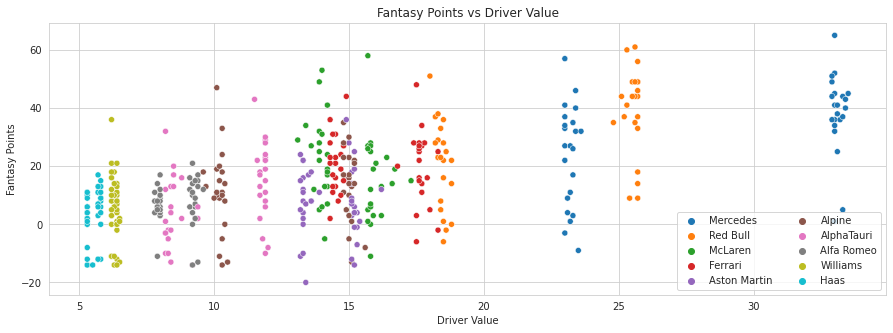

In [21]:
x_feature = 'Driver Value'
y_feature = 'Fantasy Points'
plt.figure(figsize=(15,5))
sns.scatterplot(x=driver_performance[x_feature],y=driver_performance[y_feature],hue=driver_performance['Constructor'])
plt.title(f'{y_feature} vs {x_feature}')
plt.legend(ncol=2)

#### Constructors

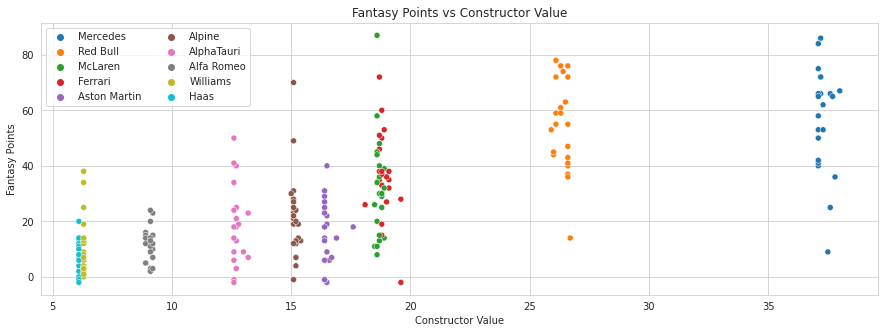

In [22]:
x_feature = 'Constructor Value'
y_feature = 'Fantasy Points'
plt.figure(figsize=(15,5))
sns.scatterplot(x=constructor_performance[x_feature],y=constructor_performance[y_feature],hue=constructor_performance['Constructor Name'])
plt.title(f'{y_feature} vs {x_feature}')
plt.legend(ncol=2)

### Fantasy Points per Dollars Spent vs Value (Cost)

The overall trend the points per dollar spent appears to be centered around a mean of about 1.5 FPts/MM. With lower cost drivers and constructors, there is a larger variance in the FPts/MM that has been achieved.

#### Driver

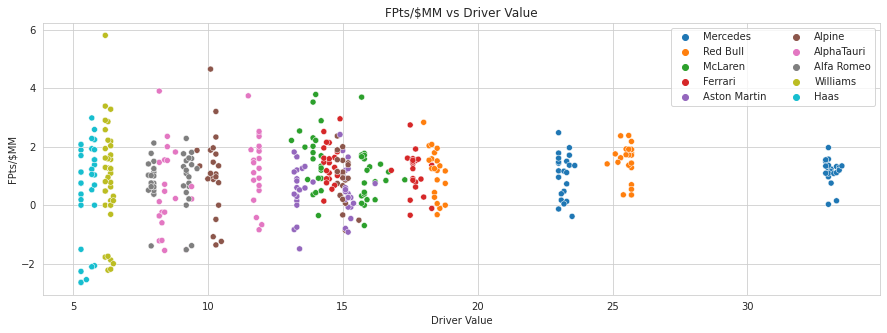

In [23]:
x_feature = 'Driver Value'
y_feature = 'FPts/$MM'
plt.figure(figsize=(15,5))
sns.scatterplot(x=driver_performance[x_feature],y=driver_performance[y_feature],hue=driver_performance['Constructor'])
plt.title(f'{y_feature} vs {x_feature}')
plt.legend(ncol=2)

#### Constructor

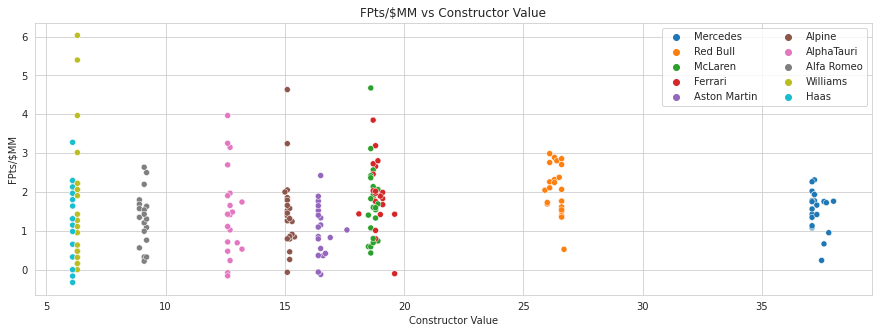

In [24]:
x_feature = 'Constructor Value'
y_feature = 'FPts/$MM'
plt.figure(figsize=(15,5))
sns.scatterplot(x=constructor_performance[x_feature],y=constructor_performance[y_feature],hue=constructor_performance['Constructor Name'])
plt.title(f'{y_feature} vs {x_feature}')
plt.legend(ncol=2)

### Fantasy Points vs Race Finish

As expected, the fantasy points are correlated very closely to the position the drivers placed. Variations are likely due to changes in position and the qualifying results. From the data below, there appears to be less variation in the top 8 places and beyond shows some larger variances in the points. This is likely due to the top constructors doing a good job of being consistent and the midfield positions are somewhat more contestable and therefore have more ability to overtake and positions change. Additionally, the lower positions are unduly impacted by large errors of typically better performing teams/drivers.

#### Driver

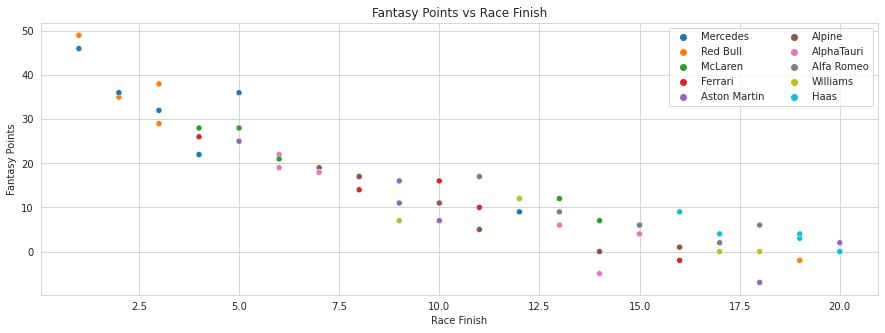

In [25]:
x_feature = 'Race Finish'
y_feature = 'Fantasy Points'
plt.figure(figsize=(15,5))
sns.scatterplot(x=driver_performance[x_feature].apply(lambda x: np.nan if type(x) == str else x),y=driver_performance[y_feature],hue=driver_performance['Constructor'])
plt.title(f'{y_feature} vs {x_feature}')
plt.legend(ncol=2)

#### Constructor

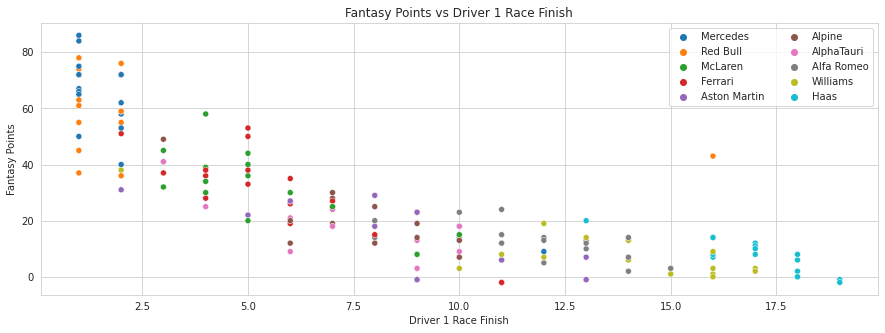

In [26]:
x_feature = 'Driver 1 Race Finish'
y_feature = 'Fantasy Points'
plt.figure(figsize=(15,5))
sns.scatterplot(x=constructor_performance[x_feature].apply(lambda x: np.nan if type(x) == str else x),y=constructor_performance[y_feature],hue=constructor_performance['Constructor Name'])
plt.title(f'{y_feature} vs {x_feature}')
plt.legend(ncol=2)

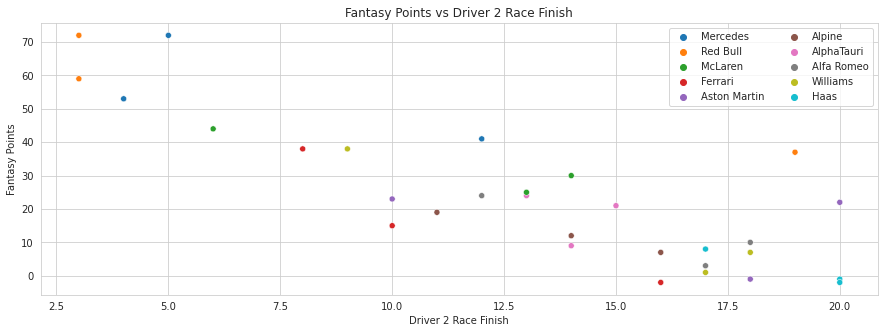

In [27]:
x_feature = 'Driver 2 Race Finish'
y_feature = 'Fantasy Points'
plt.figure(figsize=(15,5))
sns.scatterplot(x=constructor_performance[x_feature].apply(lambda x: np.nan if type(x) == str else x),y=constructor_performance[y_feature],hue=constructor_performance['Constructor Name'])
plt.title(f'{y_feature} vs {x_feature}')
plt.legend(ncol=2)

### Fantasy Points vs Finished Ahead of Teammate

The 1 denotes drivers finishing ahead of their teammate and 0 the opposite. Albeit obvious that the driver finishing ahead of the team is guaranteeing higher fantasy points, it is interesting to see the differences in mean fantasy points and variance between the various constructors. 

#### Driver

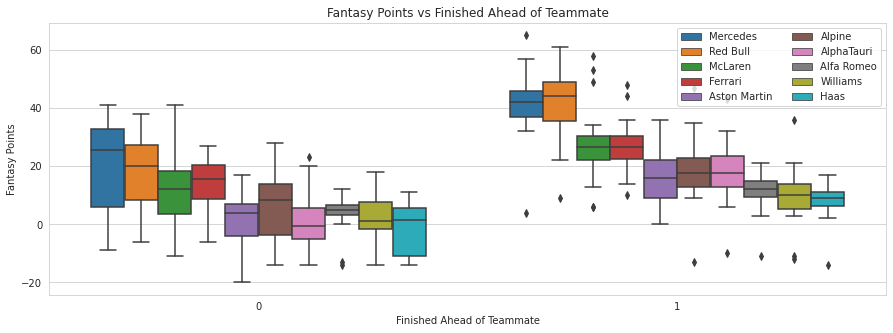

In [28]:
x_feature = 'Finished Ahead of Teammate'
y_feature = 'Fantasy Points'
plt.figure(figsize=(15,5))
sns.boxplot(x=driver_performance[x_feature].apply(lambda x: np.nan if type(x) == str else x),y=driver_performance[y_feature],hue=driver_performance['Constructor'])
plt.title(f'{y_feature} vs {x_feature}')
plt.legend(ncol=2)

Looking at the head to head match up between teammates and the frequency in which a driver finished ahead of their teammate. The results are below. Max's superb performance over the 2021 season earned him the Formula 1 World Driver's Championship and as you can see he's top of the list. Unfortunately, that meant the opposite for Checo - that said, he did put a great performance to help is teammate win the Championship with his Abu Dhabi heroics.

In [29]:
pd.DataFrame(driver_performance.groupby(by='Driver Name').sum()['Finished Ahead of Teammate']).sort_values(by='Finished Ahead of Teammate',ascending=False)

,Finished Ahead of Teammate
Driver Name,
Max Verstappen,19
Lewis Hamilton,18
Piere Gasly,17
Mick Schumacher,17
George Russell,16
Lando Norris,15
Charles Leclerc,14
Lance Stroll,12
Antonio Giovinazzi,12


### Fantasy Points vs Qualifying Position

As expected the relationship between qualifying and actual fantasy points is positively correlated. Generally speaking the better qualifying position results in more fantasy points. Obviously with a faster car, you qualify better, you stay out of traffic, and have less positions to overtake. That said, there's a considerable amount of variance in the actual fantasy points acquired. As an F1 enthusiast, I find this to be a great result because it demonstrates the variability of the races and the final result is less predictable and boring.  

#### Driver

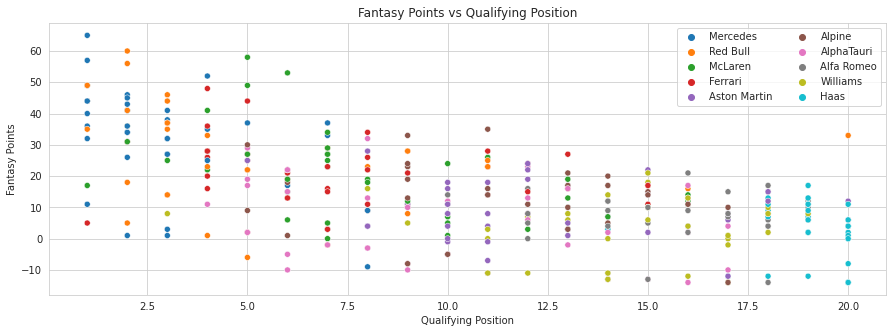

In [30]:
x_feature = 'Qualifying Position'
y_feature = 'Fantasy Points'
plt.figure(figsize=(15,5))
sns.scatterplot(x=driver_performance[x_feature].apply(lambda x: np.nan if type(x) == str else x),y=driver_performance[y_feature],hue=driver_performance['Constructor'])
plt.title(f'{y_feature} vs {x_feature}')
plt.legend(ncol=2)

#### Constructor

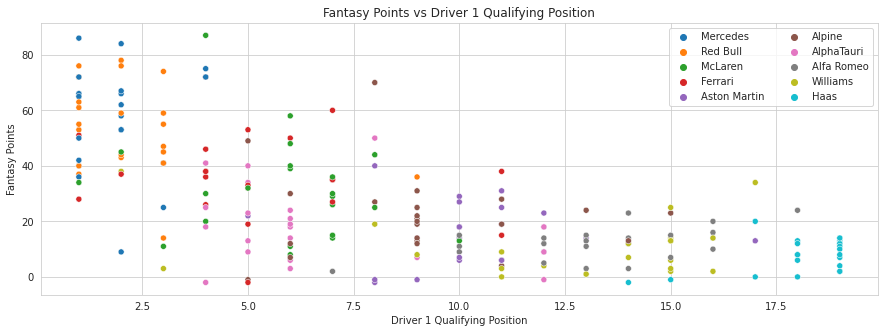

In [31]:
x_feature = 'Driver 1 Qualifying Position'
y_feature = 'Fantasy Points'
plt.figure(figsize=(15,5))
sns.scatterplot(x=constructor_performance[x_feature].apply(lambda x: np.nan if type(x) == str else x),y=constructor_performance[y_feature],hue=constructor_performance['Constructor Name'])
plt.title(f'{y_feature} vs {x_feature}')
plt.legend(ncol=2)

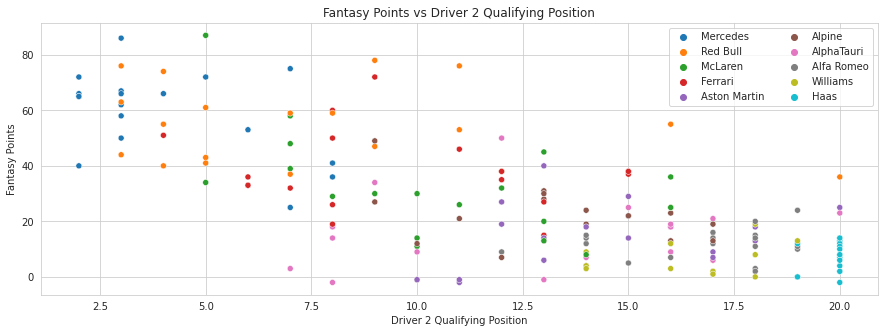

In [32]:
x_feature = 'Driver 2 Qualifying Position'
y_feature = 'Fantasy Points'
plt.figure(figsize=(15,5))
sns.scatterplot(x=constructor_performance[x_feature].apply(lambda x: np.nan if type(x) == str else x),y=constructor_performance[y_feature],hue=constructor_performance['Constructor Name'])
plt.title(f'{y_feature} vs {x_feature}')
plt.legend(ncol=2)

### Fastest Lap

In [33]:
pd.DataFrame(driver_performance.groupby('Driver Name').sum().sort_values(by='Fastest Lap',ascending=False)['Fastest Lap'])

,Fastest Lap
Driver Name,
Lewis Hamilton,6
Max Verstappen,6
Valtteri Bottas,4
Sergio Perez,2
Daniel Ricciardo,1
Piere Gasly,1
Nikita Mazepin,1
Lando Norris,1
Sebastian Vettel,0


### Race Finish vs Qualifying Position

#### Driver

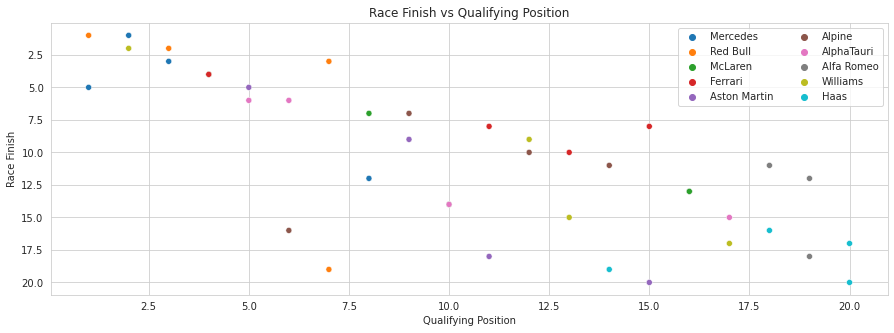

In [34]:
x_feature = 'Qualifying Position'
y_feature = 'Race Finish'
plt.figure(figsize=(15,5))
sns.scatterplot(x=driver_performance[x_feature].apply(lambda x: np.nan if type(x) == str else x),y=driver_performance[y_feature].apply(lambda x: np.nan if type(x) == str else x),hue=driver_performance['Constructor']).invert_yaxis()
plt.title(f'{y_feature} vs {x_feature}')
plt.legend(ncol=2)

#### Constructor

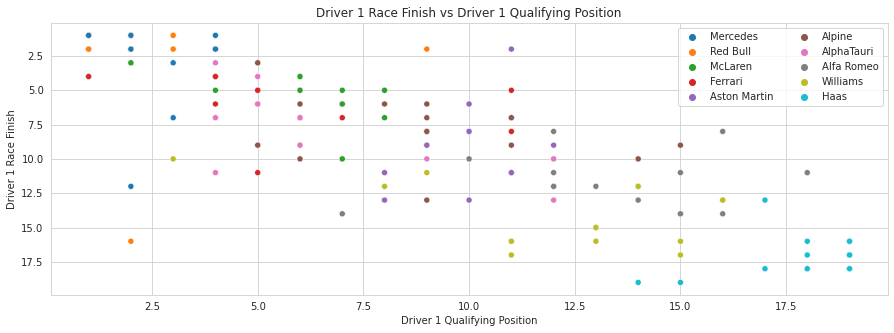

In [35]:
x_feature = 'Driver 1 Qualifying Position'
y_feature = 'Driver 1 Race Finish'
plt.figure(figsize=(15,5))
sns.scatterplot(x=constructor_performance[x_feature].apply(lambda x: np.nan if type(x) == str else x),y=constructor_performance[y_feature].apply(lambda x: np.nan if type(x) == str else x),hue=constructor_performance['Constructor Name']).invert_yaxis()
plt.title(f'{y_feature} vs {x_feature}')
plt.legend(ncol=2)

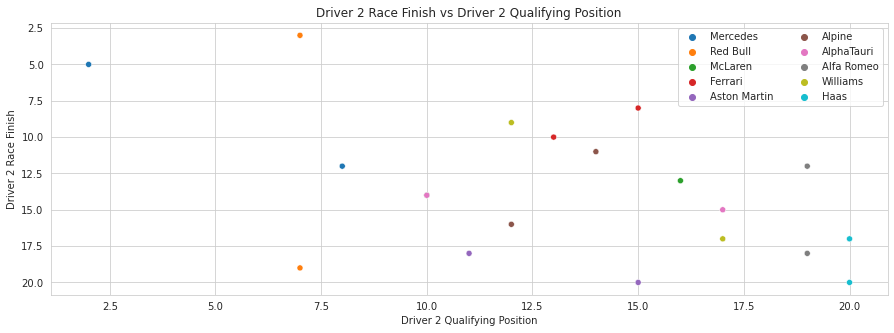

In [36]:
x_feature = 'Driver 2 Qualifying Position'
y_feature = 'Driver 2 Race Finish'
plt.figure(figsize=(15,5))
sns.scatterplot(x=constructor_performance[x_feature].apply(lambda x: np.nan if type(x) == str else x),y=constructor_performance[y_feature].apply(lambda x: np.nan if type(x) == str else x),hue=constructor_performance['Constructor Name']).invert_yaxis()
plt.title(f'{y_feature} vs {x_feature}')
plt.legend(ncol=2)

### Race Finish (Place finished) vs Value (Cost)

#### Driver

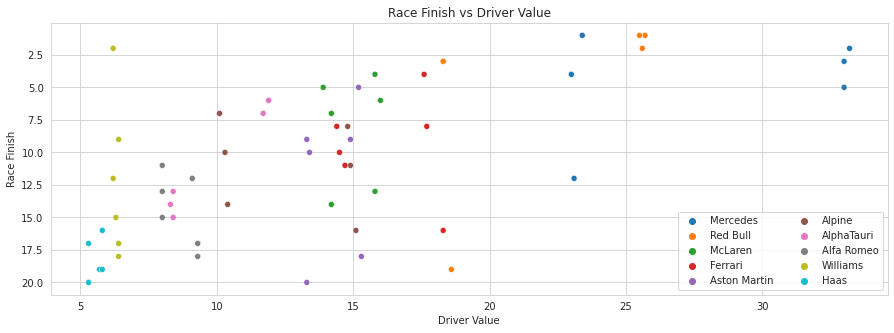

In [37]:
x_feature = 'Driver Value'
y_feature = 'Race Finish'
plt.figure(figsize=(15,5))
sns.scatterplot(x=driver_performance[x_feature].apply(lambda x: np.nan if type(x) == str else x),y=driver_performance[y_feature].apply(lambda x: np.nan if type(x) == str else x),hue=driver_performance['Constructor']).invert_yaxis()
plt.title(f'{y_feature} vs {x_feature}')
plt.legend(ncol=2)

#### Constructor

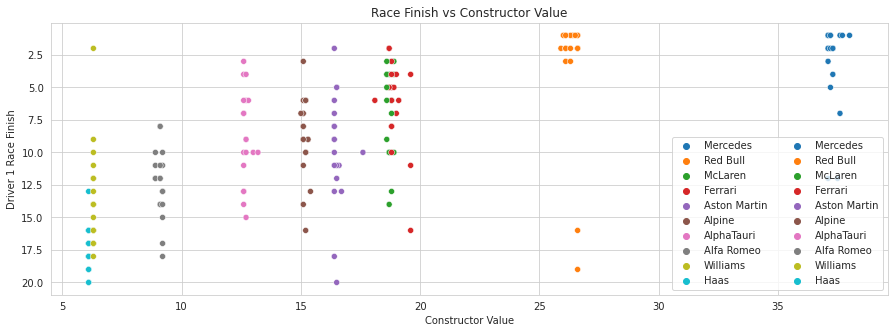

In [38]:
x_feature = 'Constructor Value'
y_feature = 'Race Finish'
y_feature_1 = 'Driver 1 Race Finish'
y_feature_2 = 'Driver 2 Race Finish'
plt.figure(figsize=(15,5))
sns.scatterplot(x=constructor_performance[x_feature].apply(lambda x: np.nan if type(x) == str else x),y=constructor_performance[y_feature_1].apply(lambda x: np.nan if type(x) == str else x),hue=constructor_performance['Constructor Name']).invert_yaxis()
sns.scatterplot(x=constructor_performance[x_feature].apply(lambda x: np.nan if type(x) == str else x),y=constructor_performance[y_feature_2].apply(lambda x: np.nan if type(x) == str else x),hue=constructor_performance['Constructor Name'])
plt.title(f'{y_feature} vs {x_feature}')
plt.legend(ncol=2)

### Qualifying Position vs Value 

#### Driver

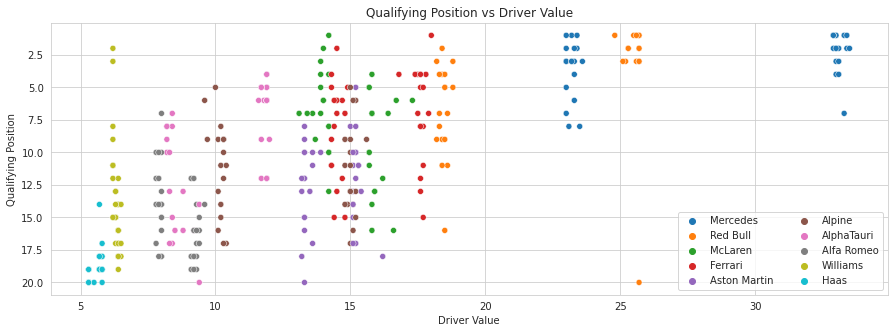

In [39]:
x_feature = 'Driver Value'
y_feature = 'Qualifying Position'
plt.figure(figsize=(15,5))
sns.scatterplot(x=driver_performance[x_feature].apply(lambda x: np.nan if type(x) == str else x),y=driver_performance[y_feature].apply(lambda x: np.nan if type(x) == str else x),hue=driver_performance['Constructor']).invert_yaxis()
plt.title(f'{y_feature} vs {x_feature}')
plt.legend(ncol=2)

#### Constructor

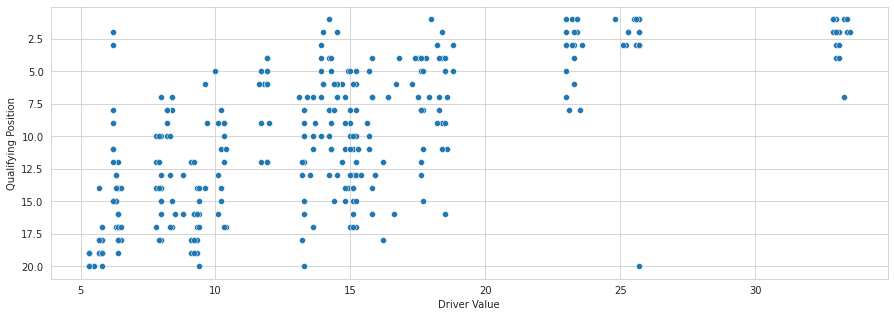

In [40]:
plt.figure(figsize=(15,5))
sns.scatterplot(x=driver_performance['Driver Value'],y=driver_performance['Qualifying Position'].apply(lambda x: np.nan if type(x) == str else x)).invert_yaxis()

### Fantasy Points vs Race Finish (Placed finished)

<AxesSubplot:xlabel='Race Finish', ylabel='Fantasy Points'>

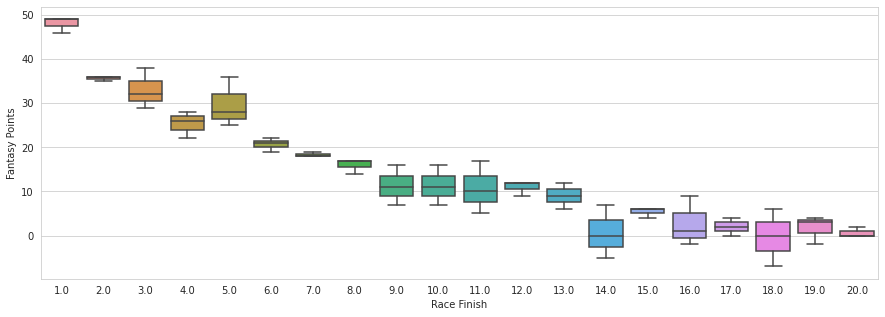

In [41]:
plt.figure(figsize=(15,5))
sns.boxplot(x=driver_performance['Race Finish'].apply(lambda x: np.nan if type(x) == str else x),y=driver_performance['Fantasy Points'])

<AxesSubplot:xlabel='Qualifying Position', ylabel='Fantasy Points'>

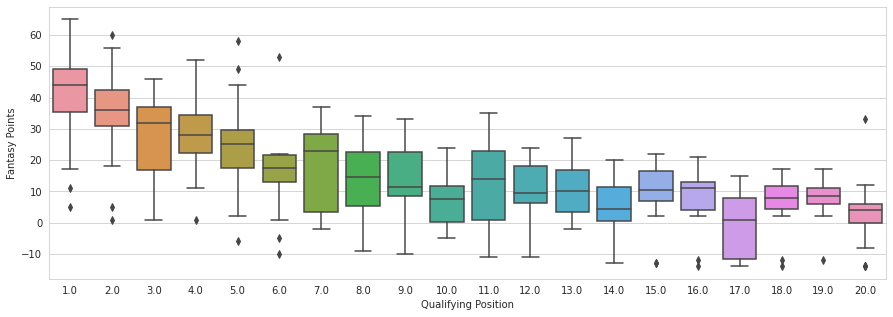

In [42]:
plt.figure(figsize=(15,5))
sns.boxplot(x=driver_performance['Qualifying Position'].apply(lambda x: np.nan if type(x) == str else x),y=driver_performance['Fantasy Points'])

<AxesSubplot:xlabel='Fastest Lap', ylabel='Fantasy Points'>

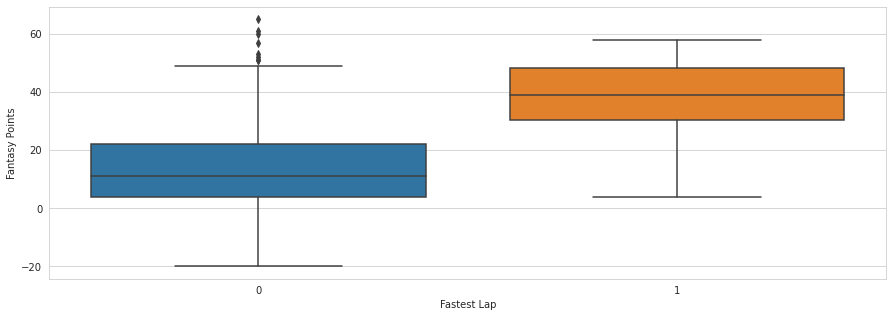

In [43]:
plt.figure(figsize=(15,5))
sns.boxplot(x=driver_performance['Fastest Lap'].apply(lambda x: np.nan if type(x) == str else x),y=driver_performance['Fantasy Points'])

<hr>

## Fantasy Points by Drivers over the season

In [44]:
df_dfpts = driver_performance.pivot(index='Driver Name',columns='Race',values='Fantasy Points')[race_schedule]
display(df_dfpts)

Race,Bahrain GP,Imola GP,Portugal GP,Spain GP,Monaco GP,Azerbaijan GP,French GP,Styrian GP,Austrian GP,British GP,...,Dutch GP,Italian GP,Russian GP,Turkish GP,USA GP,Mexican GP,Brazilian GP,Qatar GP,Saudi Arabian GP,Abu Dhabi GP
Driver Name,,,,,,,,,,,,,,,,,,,,,
Antonio Giovinazzi,5,8,8,4,11,6,6,5,10,12,...,3,8,4,17,10,3,6,8,14,-11
Carlos Sainz,11,23,2,13,36,8,10,24,28,21,...,13,23,31,17,21,19,27,15,17,44
Charles Leclerc,20,28,22,28,5,25,-2,16,15,48,...,25,34,11,26,27,26,28,27,16,3
Daniel Ricciardo,15,19,14,23,3,13,21,3,19,27,...,5,58,27,12,25,0,-11,7,26,1
Esteban Ocon,11,13,18,9,14,-13,0,8,-14,10,...,9,20,-5,11,-11,15,18,24,33,10
Fernando Alonso,-8,14,17,-5,10,23,17,11,17,35,...,23,21,22,1,-13,13,14,30,3,16
George Russell,10,-11,3,10,10,3,12,-11,5,16,...,0,21,8,6,18,8,14,6,-11,-14
Kimi Raikkonen,12,13,-13,15,9,17,2,15,2,7,...,4,10,21,12,6,16,14,11,0,-14
Lance Stroll,11,18,8,8,17,-20,7,16,0,22,...,8,22,4,11,4,12,-11,24,15,5


In [45]:
df_cfpts = constructor_performance.pivot(index='Constructor Name',columns='Race',values='Fantasy Points')[race_schedule]
display(df_cfpts)

Race,Bahrain GP,Imola GP,Portugal GP,Spain GP,Monaco GP,Azerbaijan GP,French GP,Styrian GP,Austrian GP,British GP,...,Dutch GP,Italian GP,Russian GP,Turkish GP,USA GP,Mexican GP,Brazilian GP,Qatar GP,Saudi Arabian GP,Abu Dhabi GP
Constructor Name,,,,,,,,,,,,,,,,,,,,,
Alfa Romeo,12,16,5,14,15,23,3,15,7,12,...,2,11,20,24,11,14,13,14,9,3
AlphaTauri,13,23,7,9,19,41,24,18,3,18,...,25,6,-1,9,14,34,18,-2,14,50
Alpine,13,22,30,-1,19,20,12,14,13,28,...,27,24,12,7,4,23,25,49,31,21
Aston Martin,18,14,7,6,40,31,23,18,-1,29,...,9,19,-2,-1,18,25,6,27,13,14
Ferrari,26,46,19,36,51,28,-2,35,38,72,...,33,60,37,38,33,50,53,27,38,32
Haas,7,12,10,6,11,20,-1,14,8,12,...,2,13,0,-2,4,0,8,14,2,13
McLaren,39,48,36,30,32,40,44,20,45,58,...,13,87,34,25,29,14,15,8,26,11
Mercedes,67,36,65,66,25,9,53,62,72,86,...,58,66,75,72,66,40,84,50,65,53
Red Bull,53,44,55,59,78,45,72,61,63,43,...,55,47,36,59,76,74,72,76,41,40


## FPts/$MM by Driver over the season

In [46]:
df_dppd = driver_performance.pivot(index='Driver Name',columns='Race',values=['FPts/$MM','Fantasy Points','Driver Value'])
df_dppd_rank = df_dppd['FPts/$MM'].sort_values(by=['Bahrain GP'],ascending=False).rank(ascending=False)[race_schedule]
display(df_dppd['FPts/$MM'].sort_values(by=['Bahrain GP'],ascending=False)[race_schedule])
display(df_dppd_rank)

Race,Bahrain GP,Imola GP,Portugal GP,Spain GP,Monaco GP,Azerbaijan GP,French GP,Styrian GP,Austrian GP,British GP,...,Dutch GP,Italian GP,Russian GP,Turkish GP,USA GP,Mexican GP,Brazilian GP,Qatar GP,Saudi Arabian GP,Abu Dhabi GP
Driver Name,,,,,,,,,,,,,,,,,,,,,
Lando Norris,2.213740,2.537313,1.985294,0.875912,3.525180,2.302158,2.014388,1.582734,2.214286,3.785714,...,0.915493,2.887324,1.197183,1.267606,1.338028,1.690141,0.921986,0.428571,0.359712,1.798561
Mick Schumacher,1.896552,1.929825,1.929825,1.228070,0.000000,2.586207,0.689655,2.241379,1.551724,1.379310,...,1.034483,2.241379,-2.068966,0.526316,1.228070,-2.105263,1.052632,2.280702,-2.105263,2.982456
Yuki Tsunoda,1.818182,0.638298,0.212766,-1.521739,0.227273,1.529412,0.714286,1.547619,-0.238095,2.000000,...,-1.547619,-1.204819,-0.240964,-0.602410,1.463415,-1.219512,0.121951,-0.365854,-0.365854,3.902439
George Russell,1.612903,-1.774194,0.483871,1.587302,1.587302,0.483871,1.935484,-1.774194,0.806452,2.580645,...,0.000000,3.387097,1.290323,0.952381,2.857143,1.269841,2.222222,0.952381,-1.746032,-2.222222
Max Verstappen,1.411290,1.752988,1.468254,1.620553,2.371542,0.354331,1.921569,1.725490,1.914062,0.700389,...,1.712062,0.544747,1.284047,1.367188,1.718750,1.789883,2.382812,2.178988,1.439689,1.906615
Valtteri Bottas,1.355932,-0.382979,1.367521,1.163793,0.128755,0.173160,0.956522,1.478261,1.608696,1.782609,...,1.173913,2.478261,1.434783,1.965812,1.502146,0.474138,1.709402,0.043103,1.115880,0.729614
Lewis Hamilton,1.343284,1.197605,1.287425,1.321321,1.111111,0.150150,1.084337,1.148036,0.755287,1.969697,...,1.242424,0.030303,1.575758,1.090909,1.238671,1.030303,1.550152,1.337386,1.489362,1.094225
Kimi Raikkonen,1.250000,1.382979,-1.382979,1.595745,0.967742,1.808511,0.215054,1.612903,0.215054,0.752688,...,0.434783,1.086957,2.282609,1.318681,0.659341,1.758242,1.521739,1.195652,0.000000,-1.521739
Sergio Perez,1.250000,0.271739,1.256831,1.256831,1.538462,2.833333,2.076503,1.189189,0.744681,1.170213,...,0.864865,1.513514,0.434783,1.584699,2.032967,1.793478,1.945946,1.344086,-0.324324,0.054054


Race,Bahrain GP,Imola GP,Portugal GP,Spain GP,Monaco GP,Azerbaijan GP,French GP,Styrian GP,Austrian GP,British GP,...,Dutch GP,Italian GP,Russian GP,Turkish GP,USA GP,Mexican GP,Brazilian GP,Qatar GP,Saudi Arabian GP,Abu Dhabi GP
Driver Name,,,,,,,,,,,,,,,,,,,,,
Lando Norris,1.0,1.0,1.0,14.0,1.0,5.0,2.0,5.0,1.0,1.0,...,9.0,3.0,9.0,8.0,9.0,5.0,15.0,17.0,12.0,6.0
Mick Schumacher,2.0,2.0,2.0,9.0,20.0,3.0,13.0,1.0,5.0,14.0,...,8.0,5.0,20.0,15.0,13.0,20.0,13.0,2.0,19.0,2.0
Yuki Tsunoda,3.0,15.0,18.0,20.0,17.0,9.0,12.0,6.0,19.0,6.0,...,19.0,19.0,18.0,20.0,7.0,19.0,18.0,19.0,16.0,1.0
George Russell,4.0,19.0,15.0,3.0,7.0,15.0,3.0,20.0,12.0,3.0,...,18.0,2.0,7.0,12.0,1.0,9.0,2.0,13.0,18.0,20.0
Max Verstappen,5.0,3.0,4.0,1.0,3.0,16.0,4.0,2.0,3.0,18.0,...,3.0,15.0,8.0,6.0,3.0,3.0,1.0,3.0,7.0,5.0
Valtteri Bottas,6.0,18.0,5.0,10.0,19.0,17.0,10.0,7.0,4.0,8.0,...,7.0,4.0,6.0,2.0,6.0,14.0,7.0,18.0,10.0,11.0
Lewis Hamilton,7.0,10.0,6.0,6.0,13.0,18.0,8.0,10.0,13.0,7.0,...,6.0,17.0,4.0,10.0,12.0,11.0,10.0,8.0,6.0,7.0
Kimi Raikkonen,8.5,7.0,20.0,2.0,14.0,7.0,16.0,4.0,17.0,17.0,...,14.0,13.0,1.0,7.0,14.0,4.0,11.0,9.0,14.0,18.0
Sergio Perez,8.5,16.0,7.0,7.0,8.0,2.0,1.0,9.0,15.0,15.0,...,12.0,11.0,13.0,4.0,2.0,2.0,4.0,7.0,15.0,16.0


In [47]:
df_cppd = constructor_performance.pivot(index='Constructor Name',columns='Race',values=['FPts/$MM','Fantasy Points','Constructor Value'])
df_cppd_rank = df_cppd['FPts/$MM'].sort_values(by=['Bahrain GP'],ascending=False).rank(ascending=False)[race_schedule]
display(df_cppd['FPts/$MM'].sort_values(by=['Bahrain GP'],ascending=False))
display(df_cppd_rank)

Race,Abu Dhabi GP,Austrian GP,Azerbaijan GP,Bahrain GP,Belgian GP,Brazilian GP,British GP,Dutch GP,French GP,Hungarian GP,...,Mexican GP,Monaco GP,Portugal GP,Qatar GP,Russian GP,Saudi Arabian GP,Spain GP,Styrian GP,Turkish GP,USA GP
Constructor Name,,,,,,,,,,,,,,,,,,,,,
McLaren,0.594595,2.419355,2.139037,2.063492,1.604278,0.802139,3.118280,0.695187,2.365591,0.591398,...,0.740741,1.693122,1.925134,0.430108,1.827957,1.405405,1.595745,1.075269,1.329787,1.542553
Red Bull,1.503759,2.377358,1.730769,2.046332,1.390977,2.706767,1.616541,2.067669,2.758621,0.524345,...,2.803030,2.988506,2.107280,2.857143,1.353383,1.541353,2.260536,2.319392,2.243346,2.889734
Mercedes,1.428571,1.935484,0.240000,1.763158,1.105121,2.264151,2.311828,1.563342,1.420912,1.132075,...,1.078167,0.664894,1.724138,1.347709,2.021563,1.752022,1.755319,1.662198,1.935484,1.774194
Ferrari,1.675393,2.032086,1.428571,1.436464,0.797872,2.804233,3.850267,1.755319,-0.102041,1.871658,...,2.659574,2.727273,1.010638,1.421053,1.968085,1.989529,1.894737,1.832461,2.021277,1.755319
Alfa Romeo,0.329670,0.760870,2.500000,1.348315,1.086957,1.428571,1.304348,0.219780,0.326087,1.630435,...,1.538462,1.685393,0.561798,1.538462,2.197802,0.989011,1.573034,1.630435,2.637363,1.208791
Haas,2.131148,1.311475,3.278689,1.147541,1.311475,1.311475,1.967213,0.327869,-0.163934,1.967213,...,0.000000,1.803279,1.639344,2.295082,0.000000,0.327869,0.983607,2.295082,-0.327869,0.655738
AlphaTauri,3.968254,0.236220,3.253968,1.023622,1.653543,1.428571,1.417323,1.968504,1.904762,3.149606,...,2.698413,1.484375,0.530303,-0.158730,-0.079365,1.111111,0.692308,1.428571,0.714286,1.111111
Aston Martin,0.853659,-0.060976,1.890244,1.022727,1.333333,0.365854,1.768293,0.545455,1.402439,0.365854,...,1.524390,2.424242,0.419162,1.646341,-0.121212,0.792683,0.361446,1.097561,-0.060976,1.097561
Williams,0.317460,1.269841,0.476190,0.952381,6.031746,2.222222,3.015873,1.428571,1.111111,5.396825,...,0.158730,2.063492,0.000000,0.317460,0.476190,1.904762,2.063492,0.476190,0.158730,2.222222


Race,Bahrain GP,Imola GP,Portugal GP,Spain GP,Monaco GP,Azerbaijan GP,French GP,Styrian GP,Austrian GP,British GP,...,Dutch GP,Italian GP,Russian GP,Turkish GP,USA GP,Mexican GP,Brazilian GP,Qatar GP,Saudi Arabian GP,Abu Dhabi GP
Constructor Name,,,,,,,,,,,,,,,,,,,,,
McLaren,1.0,1.0,3.0,5.0,6.0,4.0,2.0,8.0,1.0,2.0,...,7.0,1.0,4.0,5.0,5.0,8.0,9.0,8.0,6.0,8.0
Red Bull,2.0,6.0,1.0,1.0,1.0,6.0,1.0,1.0,2.0,8.0,...,1.0,6.0,5.0,2.0,1.0,1.0,2.0,2.0,5.0,4.0
Mercedes,3.0,8.0,4.0,4.0,10.0,10.0,4.0,4.0,4.0,4.0,...,5.0,5.0,2.0,4.0,3.0,7.0,3.0,7.0,4.0,5.0
Ferrari,4.0,2.0,6.0,3.0,2.0,7.0,9.0,3.0,3.0,1.0,...,4.0,3.0,3.0,3.0,4.0,3.0,1.0,6.0,2.0,3.0
Alfa Romeo,5.0,4.0,7.0,6.0,7.0,3.0,8.0,5.0,8.0,10.0,...,10.0,8.0,1.0,1.0,6.0,4.0,6.5,5.0,8.0,9.0
Haas,6.0,3.0,5.0,7.0,5.0,1.0,10.0,2.0,5.0,5.0,...,9.0,4.0,8.0,10.0,9.0,10.0,8.0,3.0,10.0,2.0
AlphaTauri,7.0,5.0,8.0,8.0,8.0,2.0,3.0,6.0,9.0,9.0,...,2.0,10.0,9.0,6.0,7.0,2.0,6.5,10.0,7.0,1.0
Aston Martin,8.0,9.0,9.0,9.0,3.0,5.0,5.0,7.0,10.0,7.0,...,8.0,9.0,10.0,9.0,8.0,5.0,10.0,4.0,9.0,7.0
Williams,9.0,10.0,10.0,2.0,4.0,9.0,6.0,10.0,6.0,3.0,...,6.0,2.0,7.0,8.0,2.0,9.0,4.0,9.0,3.0,10.0


## Best Bang for your Buck Drivers over the entire season

In [48]:
df_dppd['FPts/$MM'].mean(axis=1).sort_values(ascending=False)

Driver Name
Lando Norris          1.635440
Max Verstappen        1.537366
Carlos Sainz          1.407164
Piere Gasly           1.306778
Lewis Hamilton        1.153685
George Russell        1.145557
Charles Leclerc       1.124669
Sergio Perez          1.123833
Esteban Ocon          1.105335
Mick Schumacher       1.072843
Valtteri Bottas       1.023568
Daniel Ricciardo      0.969818
Fernando Alonso       0.895015
Kimi Raikkonen        0.882365
Antonio Giovinazzi    0.864485
Lance Stroll          0.587390
Nicholas Latifi       0.562172
Sebastian Vettel      0.538289
Yuki Tsunoda          0.440814
Nikita Mazepin        0.175893
dtype: float64

## Best Bang for your Buck Drivers by Race

In [49]:
best_value = []

for race in race_schedule:
    race_value = {}
    for rank in range(1,6):
        race_value.setdefault('Race',race)
        race_value.setdefault(f"Rank {rank}",df_dppd_rank[df_dppd_rank[race]==(rank)].index[0])
    best_value.append(race_value)
df_best_dvalue = pd.DataFrame(best_value).set_index('Race')
df_best_dvalue

,Rank 1,Rank 2,Rank 3,Rank 4,Rank 5
Race,,,,,
Bahrain GP,Lando Norris,Mick Schumacher,Yuki Tsunoda,George Russell,Max Verstappen
Imola GP,Lando Norris,Mick Schumacher,Max Verstappen,Charles Leclerc,Carlos Sainz
Portugal GP,Lando Norris,Mick Schumacher,Esteban Ocon,Max Verstappen,Valtteri Bottas
Spain GP,Max Verstappen,Kimi Raikkonen,George Russell,Charles Leclerc,Daniel Ricciardo
Monaco GP,Lando Norris,Carlos Sainz,Max Verstappen,Nikita Mazepin,Piere Gasly
Azerbaijan GP,Piere Gasly,Sergio Perez,Mick Schumacher,Sebastian Vettel,Lando Norris
French GP,Sergio Perez,Lando Norris,George Russell,Max Verstappen,Piere Gasly
Styrian GP,Mick Schumacher,Max Verstappen,Carlos Sainz,Kimi Raikkonen,Lando Norris
Austrian GP,Lando Norris,Carlos Sainz,Max Verstappen,Valtteri Bottas,Mick Schumacher


In [50]:
best_value_cost = []

for race in race_schedule:
    race_cost = {}
    for rank in range(1,6):
        race_cost.setdefault('Race',race)
        race_cost.setdefault(f"Rank {rank} Cost",df_driver_value[df_driver_value['Driver Name']==df_best_dvalue.T[race].loc[f"Rank {rank}"]][race].values[0])
    best_value_cost.append(race_cost)
# df_driver_value[df_driver_value['Driver Name'].isin(df_best_value['Bahrain GP'])]
df_best_dvalue_cost = pd.DataFrame(best_value_cost).set_index('Race')
df_best_dvalue_cost['Total Cost'] = df_best_dvalue_cost.sum(axis=1)
df_best_dvalue_cost

,Rank 1 Cost,Rank 2 Cost,Rank 3 Cost,Rank 4 Cost,Rank 5 Cost,Total Cost
Race,,,,,,
Bahrain GP,13.1,5.8,8.8,6.2,24.8,58.7
Imola GP,13.4,5.7,25.1,17.4,14.3,75.9
Portugal GP,13.6,5.7,9.6,25.2,23.4,77.5
Spain GP,25.3,9.4,6.3,17.8,16.4,75.2
Monaco GP,13.9,14.3,25.3,5.3,11.6,70.4
Azerbaijan GP,11.5,18.0,5.8,14.9,13.9,64.1
French GP,18.3,13.9,6.2,25.5,11.7,75.6
Styrian GP,5.8,25.5,14.7,9.3,13.9,69.2
Austrian GP,14.0,14.3,25.6,23.0,5.8,82.7


## Best Bang for your Buck Constructors over the entire season

In [51]:
df_cppd['FPts/$MM'].mean(axis=1).sort_values(ascending=False)

Constructor Name
Red Bull        2.070276
Ferrari         1.930961
McLaren         1.691065
Williams        1.666667
Mercedes        1.527804
Alpine          1.447890
AlphaTauri      1.443426
Alfa Romeo      1.341006
Haas            1.289121
Aston Martin    0.938545
dtype: float64

## Best Bang for your Buck Constructors

In [52]:
best_value = []

for race in race_schedule:
    race_value = {}
    for rank in range(1,6):
        race_value.setdefault('Race',race)
        race_value.setdefault(f"Rank {rank}",df_cppd_rank[df_cppd_rank[race]==(rank)].index[0])
    best_value.append(race_value)
df_best_cvalue = pd.DataFrame(best_value).set_index('Race')
df_best_cvalue

,Rank 1,Rank 2,Rank 3,Rank 4,Rank 5
Race,,,,,
Bahrain GP,McLaren,Red Bull,Mercedes,Ferrari,Alfa Romeo
Imola GP,McLaren,Ferrari,Haas,Alfa Romeo,AlphaTauri
Portugal GP,Red Bull,Alpine,McLaren,Mercedes,Haas
Spain GP,Red Bull,Williams,Ferrari,Mercedes,McLaren
Monaco GP,Red Bull,Ferrari,Aston Martin,Williams,Haas
Azerbaijan GP,Haas,AlphaTauri,Alfa Romeo,McLaren,Aston Martin
French GP,Red Bull,McLaren,AlphaTauri,Mercedes,Aston Martin
Styrian GP,Red Bull,Haas,Ferrari,Mercedes,Alfa Romeo
Austrian GP,McLaren,Red Bull,Ferrari,Mercedes,Haas


In [53]:
best_value_cost = []

for race in race_schedule:
    race_cost = {}
    for rank in range(1,6):
        race_cost.setdefault('Race',race)
        race_cost.setdefault(f"Rank {rank}",df_constructor_value[df_constructor_value['Constructor Name']==df_best_cvalue.T[race].loc[f"Rank {rank}"]][race].values[0])
    best_value_cost.append(race_cost)
# df_driver_value[df_driver_value['Driver Name'].isin(df_best_value['Bahrain GP'])]
df_best_cvalue_cost = pd.DataFrame(best_value_cost).set_index('Race')
df_best_cvalue_cost['Total'] = df_best_cvalue_cost.sum(axis=1)
df_best_cvalue_cost

,Rank 1,Rank 2,Rank 3,Rank 4,Rank 5,Total
Race,,,,,,
Bahrain GP,18.9,25.9,38.0,18.1,8.9,109.8
Imola GP,18.7,18.7,6.1,8.9,13.2,65.6
Portugal GP,26.1,15.0,18.7,37.7,6.1,103.6
Spain GP,26.1,6.3,19.0,37.6,18.8,107.8
Monaco GP,26.1,18.7,16.5,6.3,6.1,73.7
Azerbaijan GP,6.1,12.6,9.2,18.7,16.4,63.0
French GP,26.1,18.6,12.6,37.3,16.4,111.0
Styrian GP,26.3,6.1,19.1,37.3,9.2,98.0
Austrian GP,18.6,26.5,18.7,37.2,6.1,107.1


<hr>

# Buildling the Dream Team

## Simplifying assumptions:
* We won't be looking to buy / sell drivers and constructors to optimize value accumulation
* Data will be limited to what was provided here

## Approach
* We'll use the top value drivers on a FPts per Dollar basis to fill the first 5 driver positions
* The remaining budget will be used to purchase the constructor with the highest number of points.

<br>
Disclaimer: This is likely not the theoretically maximized budget lineup; however, it will be practicably close.

In [54]:
df = pd.DataFrame()
for race in race_schedule:
    budget = 100
    df_race = df_dppd[[('FPts/$MM',race),('Fantasy Points',race),('Driver Value',race)]].sort_values(by=('FPts/$MM',race),ascending=False).head(5)
    driver_cost = df_race[('Driver Value',race)].sum(axis=0)
    budget -= driver_cost
    df_temp = df_cppd[[('FPts/$MM',race),('Fantasy Points',race),('Constructor Value',race)]].sort_values(by=('Fantasy Points',race),ascending=False)
    df_temp.columns = df_temp.columns.set_levels(['FPts/$MM','Fantasy Points','Driver Value'],level=0)

    for i,row in df_temp.iterrows():
        if row['Driver Value',race] <= budget:
            df_race.loc[i] = row
            break
    df_race = df_race.reset_index(level='Driver Name',col_fill=race).T.swaplevel().T

    df = pd.concat([df,df_race],axis=1)
display(df)

Race       Bahrain GP                                               Imola GP  \
          Driver Name  FPts/$MM Fantasy Points Driver Value      Driver Name   
0        Lando Norris   2.21374           29.0         13.1     Lando Norris   
1     Mick Schumacher  1.896552           11.0          5.8  Mick Schumacher   
2        Yuki Tsunoda  1.818182           16.0          8.8   Max Verstappen   
3      George Russell  1.612903           10.0          6.2  Charles Leclerc   
4      Max Verstappen   1.41129           35.0         24.8     Carlos Sainz   
5            Mercedes  1.763158           67.0         38.0          McLaren   

Race                                            Portugal GP            ...  \
      FPts/$MM Fantasy Points Driver Value      Driver Name  FPts/$MM  ...   
0     2.537313           34.0         13.4     Lando Norris  1.985294  ...   
1     1.929825           11.0          5.7  Mick Schumacher  1.929825  ...   
2     1.752988           44.0         25.1     Esteban Ocon     1.875  ...   
3     1.609195           28.0         17.4   Max Verstappen  1.468254  ...   
4     1.608392           23.0         14.3  Valtteri Bottas  1.367521  ...   
5     2.566845           48.0         18.7          McLaren  1.925134  ...   

Race       Qatar GP                 Saudi Arabian GP                           \
     Fantasy Points Driver Value         Driver Name  FPts/$MM Fantasy Points   
0              24.0         10.3        Esteban Ocon  3.203883           33.0   
1              13.0          5.7     Nicholas Latifi   2.03125           13.0   
2              56.0         25.7         Piere Gasly  1.848739           22.0   
3              30.0         15.0  Antonio Giovinazzi  1.772152           14.0   
4              24.0         13.2    Daniel Ricciardo  1.656051           26.0   
5              76.0         26.6            Mercedes  1.752022           65.0   

Race                  Abu Dhabi GP                                        
     Driver Value      Driver Name  FPts/$MM Fantasy Points Driver Value  
0            10.3     Yuki Tsunoda  3.902439           32.0          8.2  
1             6.4  Mick Schumacher  2.982456           17.0          5.7  
2            11.9     Carlos Sainz   2.95302           44.0         14.9  
3             7.9      Piere Gasly  1.932773           23.0         11.9  
4            15.7   Max Verstappen  1.906615           49.0         25.7  
5            37.1       AlphaTauri  3.968254           50.0         12.6  

[6 rows x 88 columns]

Use the cells below to look for a particular race's (2021 season) optimal lineup. Update race variable and run the cell.

In [55]:
# Race names for reference
print(race_schedule.keys())

dict_keys(['Bahrain GP', 'Imola GP', 'Portugal GP', 'Spain GP', 'Monaco GP', 'Azerbaijan GP', 'French GP', 'Styrian GP', 'Austrian GP', 'British GP', 'Hungarian GP', 'Belgian GP', 'Dutch GP', 'Italian GP', 'Russian GP', 'Turkish GP', 'USA GP', 'Mexican GP', 'Brazilian GP', 'Qatar GP', 'Saudi Arabian GP', 'Abu Dhabi GP'])


In [56]:
race = 'Bahrain GP'
df_view = df.copy()[race]
df_view.loc['Total'] = df_view[df_view.columns[2:]].sum(axis=0)
display(df_view)

,Driver Name,FPts/$MM,Fantasy Points,Driver Value
0,Lando Norris,2.21374,29.0,13.1
1,Mick Schumacher,1.896552,11.0,5.8
2,Yuki Tsunoda,1.818182,16.0,8.8
3,George Russell,1.612903,10.0,6.2
4,Max Verstappen,1.41129,35.0,24.8
5,Mercedes,1.763158,67.0,38.0
Total,NaN,NaN,168.0,96.7


<hr>

# Discussion

## Performance Relationship Findings

### Fantasy Points vs Dollars Spent
There was a positive correlation with respect to the amount spent on either a driver or constructor, in that the more you spent, the more you could expect to earn for Fantasy points. The certainty in which that would be the case obviously had variance with how the drivers performed over the course of the season.

There was a great deal of variation in the point production across all drivers and constructors which leads to more uncertain results and generally a more exciting experience for the spectators. Additionally, this variation is what makes it more interesting for the Formula 1 fans to speculate and change lineups in attempt to get an edge on other competitors.

### Optimizing Value of your Budget
The set of this fantasy league is restricted by the budget every player is working with. In our case, we were running on a 100MM budget. The obvious solution would be to buy all the best drivers and constructors; however, that is not possible given that would require a budget that would be roughly 1.6 times in size. Even if that strategy were used, that would not have guaranteed you the best performance given the variations in performance.

Thus with this restriction, choices need to be made with regard to getting the most value out of your precious dollars. I have gone with a fantasy points per dollar spent (cost) as a means to maximize fantasy point production. This offers obvious opportunities to find value gems in the mid and back field. Granted they generate less points because they aren't scoring the blockbuster points; however, they also cost significantly less.

When looking at the relationship between the fantasy points scored per dollar spent vs the dollars spent (Driver/Constructor Value), the results were very interesting. On the driver field, the majority of the drivers' points per dollar performance were centered around an average of 1 pts/MM dollars and by spending more money for elite drivers, the variance in the fantasy points decreased. There is more certainty that the pricey drivers will deliver on their expected point production.

As you go down on the amount you are looking to spend, the variance increases significantly meaning there is opportunity to get much better value than the elite drivers and the risk of not getting any value at all.





<hr>

# Conclusion

Based on the data seen above, Formula 1 Fantasy (at least in the 2021 season) has been a bit more variable than it likely has been in the past seasons. Incorporating a fixed budget adds a significant opportunity to optimize your fantasy team lineup.

Key things to pay attention to...
* Maximizing value - are you getting the fantasy points for the money that you spending
* Consistency matters - there can be significant variances in fantasy points depending on the position you
* Drivers / Constructors' value is highly correlated with how they were assess at the beginning of the season
* Changes in value were insignificant to the value initially placed on drivers / constructors

Things I thought were surprising
* Lewis Hamilton is worth the money. Despite the high cost of having him on your lineup, his consistency in scoring high points makes him extremely attractive. Expensive doesn't necessarily mean he's overvalued.
* The cost premium of drivers doesn't necessarily erode your fantasy points per dollar spent. It does reduce it's variance so you can reliably count on the consistency to provide the value that other lower cost drivers aren't able to generate.

## The Dream Team
As promised and based on the data and analysis above, the team that would have netted you the most points over the season is as follows:
1. Lando Norris
2. Max Verstappen
3. Carlos Sainz
4. Piere Gasly
5. Lewis Hamilton
6. George Russell (if budget doesn't allow for Lewis, George is the next best choice)
1. Red Bull
2. Ferrari (alternative choice if budget didn't allow for owning Red Bull)

For the theoretical optimal line up see the discussion and review the various races for the corresponding "best team".


# Thank you!
If you've made it this far, thanks for checking out this notebook and I hope this helps your future Formula 1 Fantasy team selection efforts. I know it has informed me about some of the various factors!

Looking forward to an exciting new season with new regulations and hopefully the changes introduce some new dynamics and results!
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
